# Final Assignment CSE 368
prwilkin, adong4, duncenzh

**Citations:**
---
Environment 1:
> Dataset is curated/modified; US Department of Transportation Federal Highway Administration Route Log and Finder List “Table 4: Major Cities Served by Interstate Routes (2010 Census Populations greater than 50,000)”,

> NetworkX library; Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008,

> Pandas library; McKinney, W., & others. (2010). Data structures for statistical computing in python. In Proceedings of the 9th Python in Science Conference (Vol. 445, pp. 51–56),

Environment 2:
> Numpy library; Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). DOI: 10.1038/s41586-020-2649-2,

> Classes State, Node, & Problem modified; fall23 cse368 assignment 1 base code provided by Professor Alina Vereshchaka and TA’s

# Environment 1
'data.xlsx' is a dataset for our first environment. Add this file, which is in the zip drive, to your drive Then Load from Drive, data.xlsx.

In [ ]:
!pwd
!ls

In [17]:
from google.colab import drive
drive.mount('/content/drive')
# !!! FILE PATH MAY HAVE TO BE CHANGED TO ALLOW YOU TO RUN !!!
%cd ..
%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive
/content/drive/MyDrive


In [18]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def generate(datafile, graph):
    for index, row in datafile.iterrows():
        # Node will be named after 'city, state'
        node_name = f"{row['city']}, {row['state']}"
        # Parse lists
        connected_cities = row['connected cities'].split(',')
        connected_states = row['connected cities states'].split(',')
        distances = [int(dist) for dist in row['distance to city'].split(',')]

        # Add the current city if not already in graph or update with lat, long, & interstates
        graph.add_node(node_name, lat=row['lat'], long=row['long'], interstates=row['interstates'])

        # Add edges
        for i, (connected_city, connected_state) in enumerate(zip(connected_cities, connected_states)):
            connected_city_state = f"{connected_city.strip()}, {connected_state.strip()}"
            if connected_city_state not in graph:
                graph.add_node(connected_city_state)
            # Distance is cost
            graph.add_edge(node_name, connected_city_state, distance=distances[i])


def visual(search, route):

    # Store data
    city = list(data['city'])
    state = list(data['state'])
    lat = list(data['lat'])
    long = list(data['long'])

    # Visual
    plt.figure(figsize=(80, 48))
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    plt.title(search + ' on US Cities and Interstates', size=125)
    plt.ylabel('Latitude', size=110)
    plt.xlabel('Longitude', size=110)
    plt.tick_params(axis='y', labelsize=60)
    plt.tick_params(axis='x', labelsize=60)
    plt.grid(True, which='both', lw=2)

    # Plotting
    plt.scatter(long, lat, lw=10)
    # fig, mapping = plt.subplots()
    # mapping.scatter(long, lat)
    for i, (c, st) in enumerate(zip(city, state)):
        txt = c + ', ' + st
        plt.annotate(txt, (long[i], lat[i]), size=10)

    # New data load
    citystate = [rtn for rtn in zip(city, state)]
    longlat = [rtn for rtn in zip(long, lat)]
    lookuptable = dict([rtn for rtn in zip(citystate, longlat)])
    citiescon = list(data['connected cities'])
    statecon = list(data['connected cities states'])
    for i, (long1, lat1) in enumerate(longlat):
        connected_cities = citiescon[i].split(', ')
        connected_states = statecon[i].split(', ')
        linesToDraw = zip(connected_cities, connected_states)
        for value in linesToDraw:
            longlat2 = lookuptable[value]
            long2 = longlat2[0]
            lat2 = longlat2[1]

            # draw line from long1 lat1 to long2 lat2
            plt.plot(list([long1, long2]), list([lat1, lat2]), lw=4, color='r')

    # now plot path
    coordinatesPath = list()
    for value in route:
        pathcity, pathstate = value.split(', ')
        coordinatesPath.append(lookuptable[pathcity, pathstate])
    i = 0
    while i < len(coordinatesPath)-1:
        longlat1 = coordinatesPath[i]
        long1 = longlat1[0]
        lat1 = longlat1[1]
        longlat2 = coordinatesPath[i + 1]
        long2 = longlat2[0]
        lat2 = longlat2[1]
        plt.plot(list([long1, long2]), list([lat1, lat2]), linestyle='dotted', lw=8, color='yellow')
        i += 1

    plt.show()


In [21]:
import random
import time
from queue import PriorityQueue

# Load dataset
file = './data.xlsx'
data = pd.read_excel(file)

# Initialize graph
G = nx.Graph()
generate(data, G)

def bfs(start_city, end_city):
    counter = 0
    queue = []
    visited = []
    route = []
    previous_cities = []

    queue.append(start_city)

    start_time = time.time()

    while queue:
        current_city = queue.pop(0)
        visited.append(current_city)
        counter += 1

        if current_city == end_city:
            end_time = time.time() - start_time
            print("BFS ran for: ", end_time, " seconds")
            route.append(end_city)

            # route creating
            city = end_city
            for i in range(counter):  # amount of times loopings needed to be done (not too sure if needed)
                for cities in previous_cities:  # loops through list of city to check
                    if city == cities[0]:  # matches the city to find the previous city
                        route.append(cities[1])  # adds previous city to the route
                        city = cities[1]  # updates the city to backtrack
            # route.reverse()
            # print(route)
            # print(counter)
            return route, counter

        for connected_cities in G.edges(current_city):
            if connected_cities[1] not in visited:
                queue.append(connected_cities[1])
                previous_cities.append([connected_cities[1], current_city])  # to help backtrack later on


def greedy(start_city, end_city):
    priority_queue = PriorityQueue()
    visited = set()
    route = []
    previous_cities = []
    counter = 0
    start_node_tuple = (0, start_city)

    list_of_connected_cities_and_distance = []
    for edge in G.edges.data():
        list_of_connected_cities_and_distance.append(list([edge[0], edge[1], int(edge[2]['distance'])]))

    start_time = time.time()
    priority_queue.put(start_node_tuple)

    while priority_queue:
        counter += 1
        tup = priority_queue.get()
        distance, parent_city = tup[0], tup[1]
        visited.add(parent_city)
        if parent_city == end_city:
            route.append(end_city)
            end_time = time.time() - start_time
            print("Greedy ran for: ", end_time, " seconds")

            # route creating
            city = end_city
            for i in range(counter):  # amount of times loopings needed to be done (not too sure if needed)
                for the_cities in previous_cities:  # loops through list of city to check
                    if city == the_cities[1]:  # matches the city to find the previous city
                        route.append(the_cities[0])  # adds previous city to the route
                        city = the_cities[0]  # updates the city to backtrack
            # route.reverse()
            # print(route)
            # print(distance)
            # print(counter)
            return route, distance, counter

        cities = []
        for connected_cities in G.edges(parent_city):
            for find_distance in list_of_connected_cities_and_distance:
                if connected_cities[0] in find_distance and connected_cities[1] in find_distance:
                    distance_of_connected_cities = find_distance[2]
            if connected_cities[1] not in visited:
                tuple_placeholder = (distance_of_connected_cities + distance, connected_cities[1])
                cities.append(tuple_placeholder)
                child_tup = tuple_placeholder
                priority_queue.put(child_tup)
                newcity, newdistance = child_tup[1], child_tup[0]
                previous_cities.append((parent_city, newcity))

def random_two_cities(twocities):
    random_cities = random.choice(twocities)
    random_first_city = random_cities
    random_cities = random.choice(twocities)
    random_second_city = random_cities
    while random_first_city == random_second_city:
        random_cities = random.choice(twocities)
        random_second_city = random_cities
    random_first_city = str(random_first_city[0]) + ', ' + str(random_first_city[1])
    random_second_city = str(random_second_city[0]) + ', ' + str(random_second_city[1])
    return random_first_city, random_second_city


Grand Junction, CO Saratoga Springs, NY
BFS ran for:  0.0031974315643310547  seconds


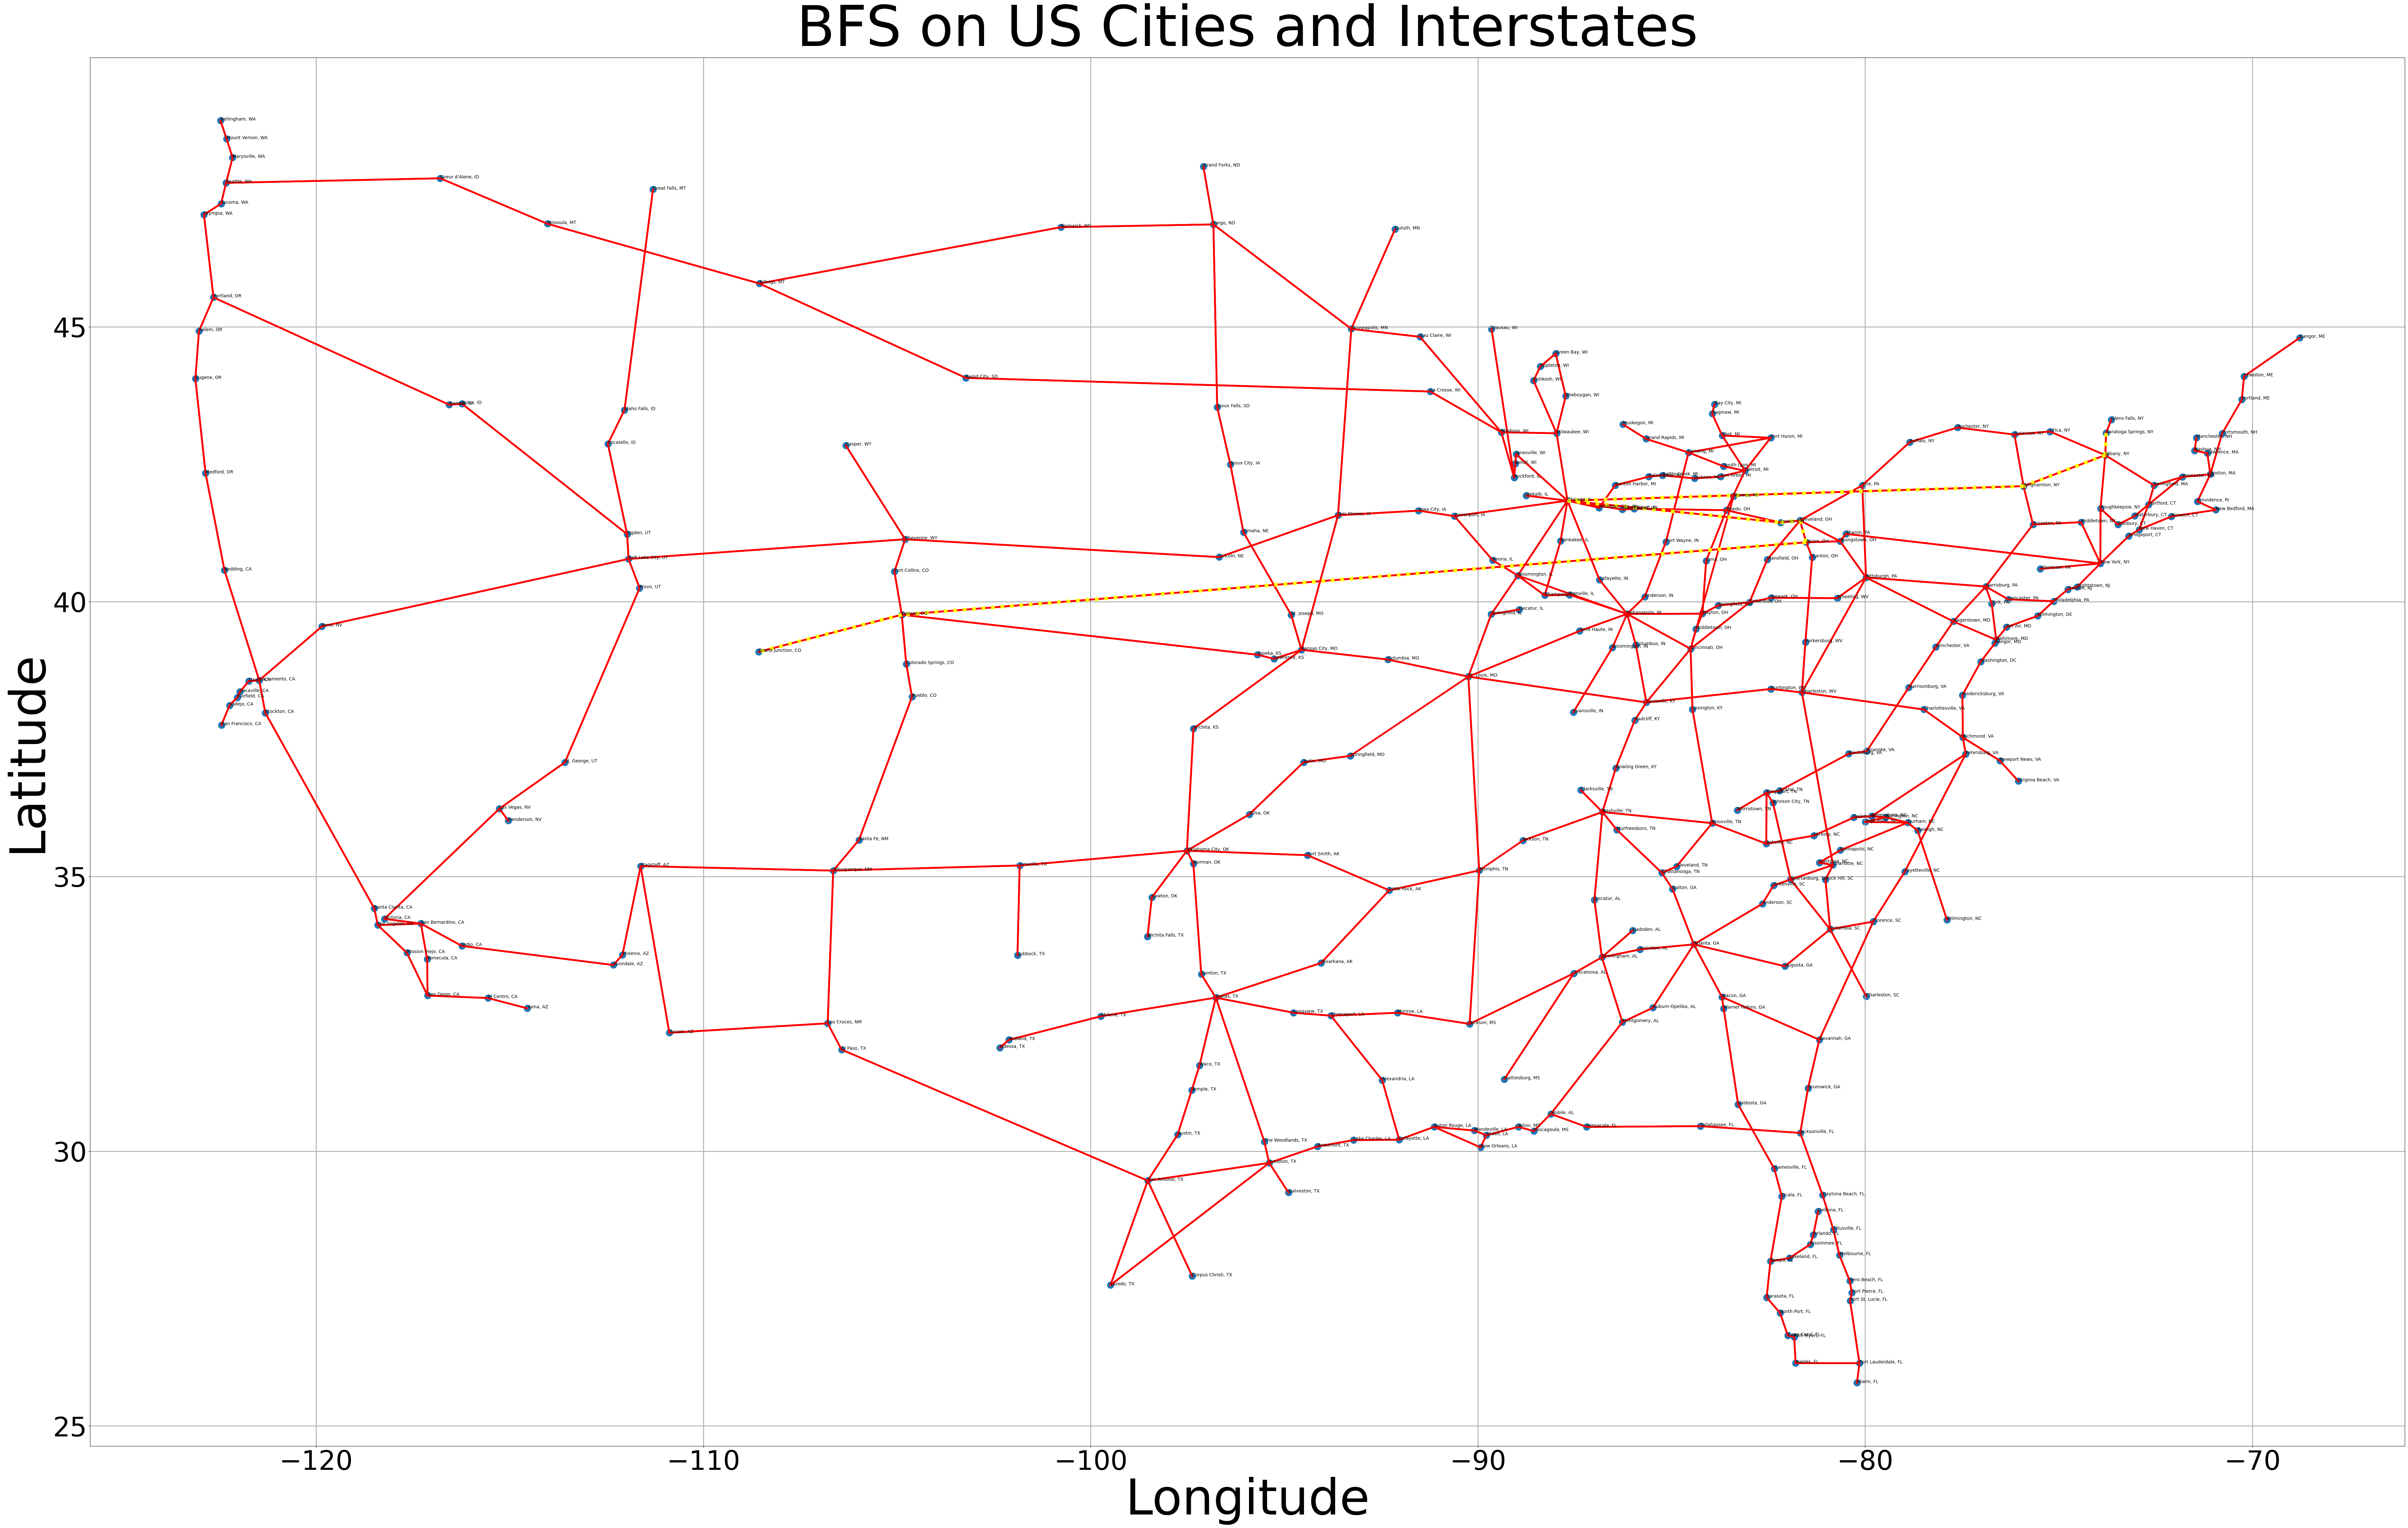

Node Count for BFS:  229
Greedy ran for:  0.15528416633605957  seconds


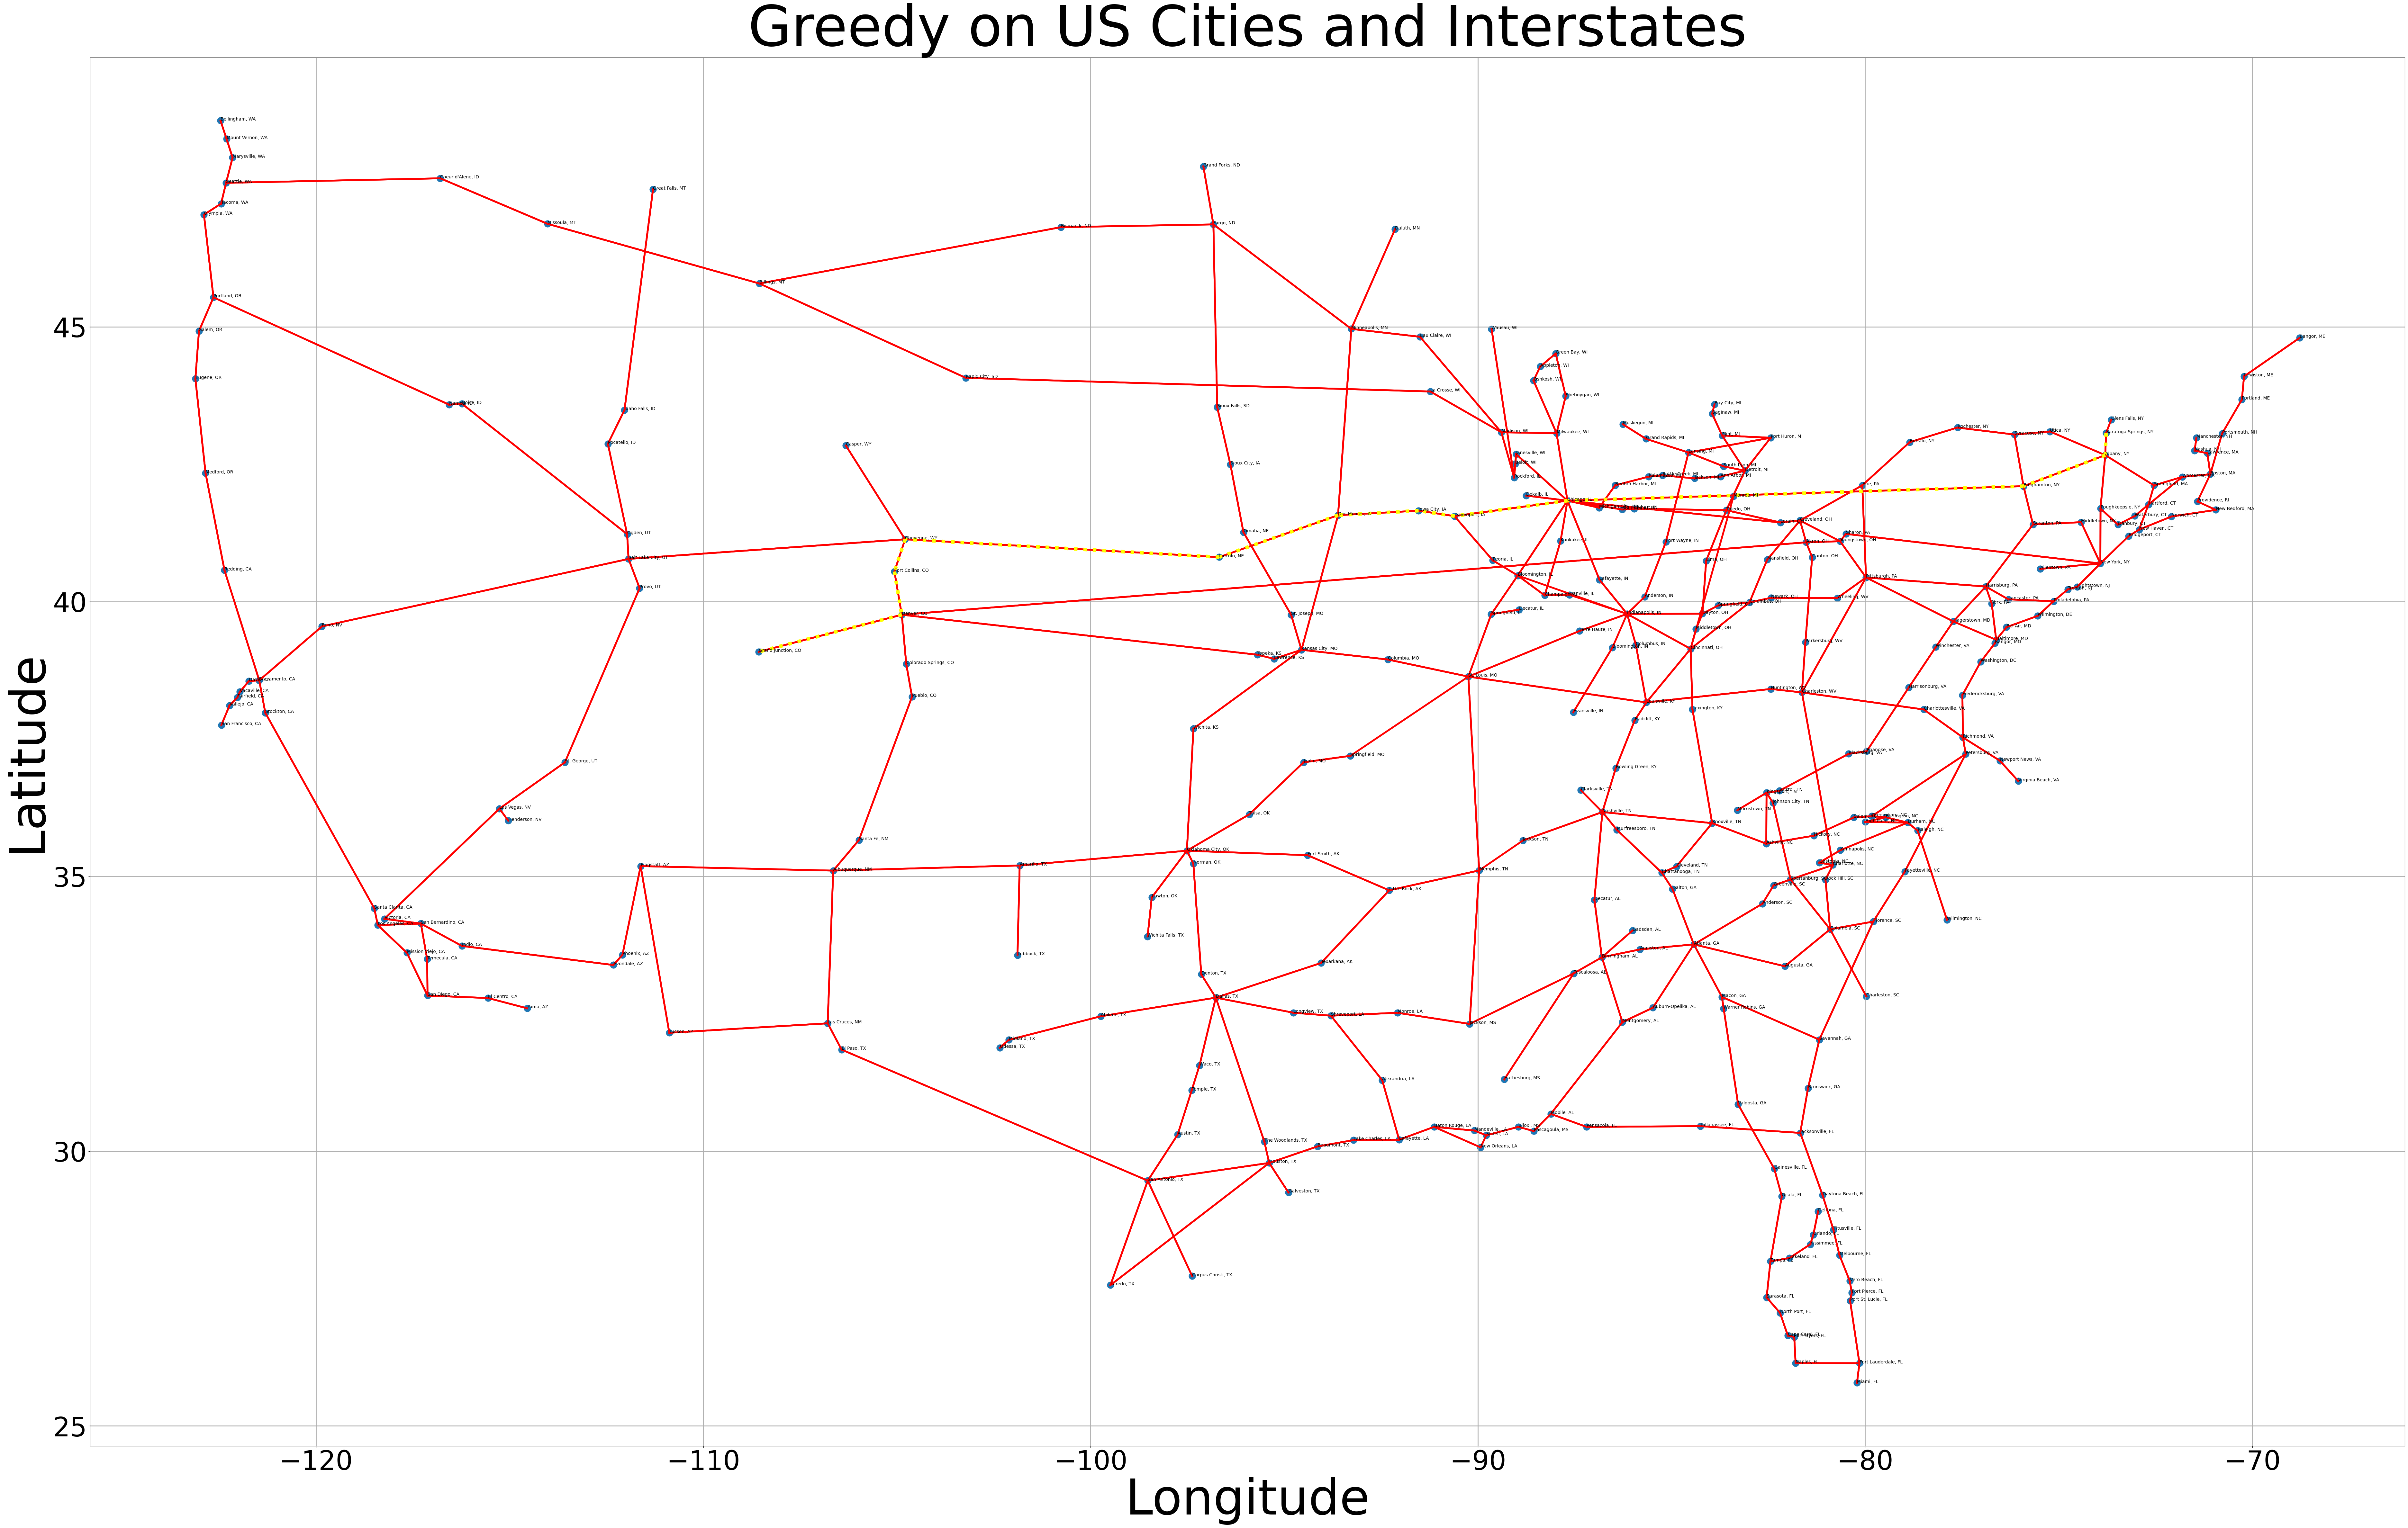

Node Count for Greedy:  524  || Distance:  3109452  meters


In [22]:
# pick start and end cities
randCity = list(data['city'])
randState = list(data['state'])
randCityState = [rtn for rtn in zip(randCity, randState)]
RandCity1, RandCity2 = random_two_cities(randCityState)
print(RandCity1, RandCity2)
# Manual selections of cities can be made by passing parameters formed like this: 'Santa Clarita, CA', 'Charleston, WV'

# BFS
pathBFS, countBFS = bfs(RandCity1, RandCity2)
visual('BFS', pathBFS)
print("Node Count for BFS: ", countBFS)

# Greedy
pathGreedy, distanceGreedy, countGreedy = greedy(RandCity1, RandCity2)
visual('Greedy', pathGreedy)
print("Node Count for Greedy: ", countGreedy, " || Distance: ", distanceGreedy, " meters")

# Environment 2

In [23]:
import numpy as np
import random


class State:
    boardSize = 10

    def __init__(self, s=None):
        if s is None:
            self.boardType = random.randint(0, 5)
            if self.boardType == 0:
                #                       0, 1, 2, 3, 4, 5, 6, 7, 8, 9          0, 1, 2, 3, 4, 5, 6, 7, 8, 9
                self.board = np.array([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 0 | S  ~  ~  ~  ~  ~  ~  ~  ~  ~
                                       [1, 0, 1, 1, 1, 1, 1, 1, 0, 0],  # 1 | ~  =  ~  ~  ~  ~  ~  ~  =  =
                                       [1, 1, 0, 1, 0, 1, 0, 1, 1, 1],  # 2 | ~  ~  =  ~  =  ~  =  ~  ~  ~
                                       [1, 1, 0, 1, 1, 1, 1, 1, 0, 1],  # 3 | ~  ~  =  ~  ~  ~  ~  ~  =  ~
                                       [1, 1, 1, 1, 0, 1, 0, 1, 0, 1],  # 4 | ~  ~  ~  ~  =  ~  =  ~  =  ~
                                       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],  # 5 | =  =  =  ~  ~  ~  ~  ~  ~  ~
                                       [3, 1, 1, 1, 1, 0, 1, 1, 0, 1],  # 6 | @  ~  ~  ~  ~  =  ~  ~  =  ~
                                       [0, 0, 0, 1, 1, 0, 1, 1, 1, 1],  # 7 | =  =  =  ~  ~  =  ~  ~  ~  ~
                                       [1, 1, 0, 1, 0, 0, 0, 1, 0, 0],  # 8 | ~  ~  =  ~  =  =  =  ~  =  =
                                       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 9 | ~  ~  ~  ~  ~  ~  ~  ~  ~  ~
                                       ])
                self.goalpos = [6, 0]
            elif self.boardType == 1:
                #                       0, 1, 2, 3, 4, 5, 6, 7, 8, 9          0, 1, 2, 3, 4, 5, 6, 7, 8, 9
                self.board = np.array([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 0 | S  ~  ~  ~  ~  ~  ~  ~  ~  ~
                                       [1, 0, 1, 1, 1, 1, 1, 1, 0, 0],  # 1 | ~  =  ~  ~  ~  ~  ~  ~  =  =
                                       [1, 1, 0, 1, 0, 1, 0, 1, 1, 1],  # 2 | ~  ~  =  ~  =  ~  =  ~  ~  ~
                                       [1, 1, 0, 1, 1, 1, 1, 1, 0, 1],  # 3 | ~  ~  =  ~  ~  ~  ~  ~  =  ~
                                       [1, 1, 1, 1, 0, 1, 0, 1, 0, 1],  # 4 | ~  ~  ~  ~  =  ~  =  ~  =  ~
                                       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],  # 5 | =  =  =  ~  ~  ~  ~  ~  ~  ~
                                       [1, 1, 1, 1, 1, 0, 1, 1, 0, 1],  # 6 | ~  ~  ~  ~  ~  =  ~  ~  =  ~
                                       [0, 0, 0, 1, 1, 0, 1, 1, 1, 1],  # 7 | =  =  =  ~  ~  =  ~  ~  ~  ~
                                       [3, 1, 0, 1, 0, 0, 0, 1, 0, 0],  # 8 | @  ~  =  ~  =  =  =  ~  =  =
                                       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 9 | ~  ~  ~  ~  ~  ~  ~  ~  ~  ~
                                       ])
                self.goalpos = [8, 0]
            elif self.boardType == 2:
                #                       0, 1, 2, 3, 4, 5, 6, 7, 8, 9          0, 1, 2, 3, 4, 5, 6, 7, 8, 9
                self.board = np.array([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 0 | S  ~  ~  ~  ~  ~  ~  ~  ~  ~
                                       [1, 0, 1, 1, 1, 1, 1, 1, 0, 0],  # 1 | ~  =  ~  ~  ~  ~  ~  ~  =  =
                                       [1, 1, 0, 1, 0, 1, 0, 1, 1, 1],  # 2 | ~  ~  =  ~  =  ~  =  ~  ~  ~
                                       [1, 1, 0, 1, 1, 3, 1, 1, 0, 1],  # 3 | ~  ~  =  ~  ~  @  ~  ~  =  ~
                                       [1, 1, 1, 1, 0, 1, 0, 1, 0, 1],  # 4 | ~  ~  ~  ~  =  ~  =  ~  =  ~
                                       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],  # 5 | =  =  =  ~  ~  ~  ~  ~  ~  ~
                                       [1, 1, 1, 1, 1, 0, 1, 1, 0, 1],  # 6 | ~  ~  ~  ~  ~  =  ~  ~  =  ~
                                       [0, 0, 0, 1, 1, 0, 1, 1, 1, 1],  # 7 | =  =  =  ~  ~  =  ~  ~  ~  ~
                                       [1, 1, 0, 1, 0, 0, 0, 1, 0, 0],  # 8 | ~  ~  =  ~  =  =  =  ~  =  =
                                       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 9 | ~  ~  ~  ~  ~  ~  ~  ~  ~  ~
                                       ])
                self.goalpos = [3, 5]
            elif self.boardType == 3:
                #                       0, 1, 2, 3, 4, 5, 6, 7, 8, 9          0, 1, 2, 3, 4, 5, 6, 7, 8, 9
                self.board = np.array([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3],  # 0 | S  ~  ~  ~  ~  ~  ~  ~  ~  @
                                       [1, 0, 1, 1, 1, 1, 1, 1, 0, 0],  # 1 | ~  =  ~  ~  ~  ~  ~  ~  =  =
                                       [1, 1, 0, 1, 0, 1, 0, 1, 1, 1],  # 2 | ~  ~  =  ~  =  ~  =  ~  ~  ~
                                       [1, 1, 0, 1, 1, 1, 1, 1, 0, 1],  # 3 | ~  ~  =  ~  ~  ~  ~  ~  =  ~
                                       [1, 1, 1, 1, 0, 1, 0, 1, 0, 1],  # 4 | ~  ~  ~  ~  =  ~  =  ~  =  ~
                                       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],  # 5 | =  =  =  ~  ~  ~  ~  ~  ~  ~
                                       [1, 1, 1, 1, 1, 0, 1, 1, 0, 1],  # 6 | ~  ~  ~  ~  ~  =  ~  ~  =  ~
                                       [0, 0, 0, 1, 1, 0, 1, 1, 1, 1],  # 7 | =  =  =  ~  ~  =  ~  ~  ~  ~
                                       [1, 1, 0, 1, 0, 0, 0, 1, 0, 0],  # 8 | ~  ~  =  ~  =  =  =  ~  =  =
                                       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 9 | ~  ~  ~  ~  ~  ~  ~  ~  ~  ~
                                       ])
                self.goalpos = [0, 9]
            elif self.boardType == 4:
                #                       0, 1, 2, 3, 4, 5, 6, 7, 8, 9          0, 1, 2, 3, 4, 5, 6, 7, 8, 9
                self.board = np.array([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 0 | S  ~  ~  ~  ~  ~  ~  ~  ~  ~
                                       [1, 0, 1, 1, 1, 1, 1, 1, 0, 0],  # 1 | ~  =  ~  ~  ~  ~  ~  ~  =  =
                                       [1, 1, 0, 1, 0, 1, 0, 1, 1, 1],  # 2 | ~  ~  =  ~  =  ~  =  ~  ~  ~
                                       [1, 1, 0, 1, 1, 1, 1, 1, 0, 1],  # 3 | ~  ~  =  ~  ~  ~  ~  ~  =  ~
                                       [1, 1, 1, 1, 0, 1, 0, 1, 0, 3],  # 4 | ~  ~  ~  ~  =  ~  =  ~  =  @
                                       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],  # 5 | =  =  =  ~  ~  ~  ~  ~  ~  ~
                                       [1, 1, 1, 1, 1, 0, 1, 1, 0, 1],  # 6 | ~  ~  ~  ~  ~  =  ~  ~  =  ~
                                       [0, 0, 0, 1, 1, 0, 1, 1, 1, 1],  # 7 | =  =  =  ~  ~  =  ~  ~  ~  ~
                                       [1, 1, 0, 1, 0, 0, 0, 1, 0, 0],  # 8 | ~  ~  =  ~  =  =  =  ~  =  =
                                       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 9 | ~  ~  ~  ~  ~  ~  ~  ~  ~  ~
                                       ])
                self.goalpos = [4, 9]
            elif self.boardType == 5:
                #                       0, 1, 2, 3, 4, 5, 6, 7, 8, 9          0, 1, 2, 3, 4, 5, 6, 7, 8, 9
                self.board = np.array([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # 0 | S  ~  ~  ~  ~  ~  ~  ~  ~  ~
                                       [1, 0, 1, 1, 1, 1, 1, 1, 0, 0],  # 1 | ~  =  ~  ~  ~  ~  ~  ~  =  =
                                       [1, 1, 0, 1, 0, 1, 0, 1, 1, 1],  # 2 | ~  ~  =  ~  =  ~  =  ~  ~  ~
                                       [1, 1, 0, 1, 1, 1, 1, 1, 0, 1],  # 3 | ~  ~  =  ~  ~  ~  ~  ~  =  ~
                                       [1, 1, 1, 1, 0, 1, 0, 1, 0, 1],  # 4 | ~  ~  ~  ~  =  ~  =  ~  =  ~
                                       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],  # 5 | =  =  =  ~  ~  ~  ~  ~  ~  ~
                                       [1, 1, 1, 1, 1, 0, 1, 1, 0, 1],  # 6 | ~  ~  ~  ~  ~  =  ~  ~  =  ~
                                       [0, 0, 0, 1, 1, 0, 1, 1, 1, 1],  # 7 | =  =  =  ~  ~  =  ~  ~  ~  ~
                                       [1, 1, 0, 1, 0, 0, 0, 1, 0, 0],  # 8 | ~  ~  =  ~  =  =  =  ~  =  =
                                       [1, 1, 1, 1, 1, 1, 1, 1, 1, 3],  # 9 | ~  ~  ~  ~  ~  ~  ~  ~  ~  @
                                       ])
                self.goalpos = [9, 9]
            # position
            self.position = [0, 0]
        else:
            self.board = np.empty_like(s.board)
            self.board[:] = s.board

            self.position = list(s.position)
            self.goalpos = list(s.goalpos)

    # converts to readable string to print
    def __str__(self):
        rstr = ''
        for row in self.board:
            rstr += str(row) + '\n'
        return rstr

    # overload to allow comparison of lists and states with ==
    def __eq__(self, other):
        if isinstance(other, State):
            return np.array_equal(self.board, other.board)
        elif isinstance(other, list):
            return self.board == other
        else:
            return NotImplemented

    # turn into immutable object for set lookup
    def toTuple(self):
        tpl = ()
        for row in self.board:
            tpl += (tuple(row),)
        return tpl


class Node:
    """
    Attributes:
    - p: The parent node.
    - a: The action that led to this node from the parent.
    - c: The cost associated with reaching this node.
    - s: The state represented by this node.
    - d: The depth of this node in the search tree.
    """
    nodeCount = 0

    def __init__(self, p, a, c, s, d):
        # keep track of how many nodes were created
        self.__class__.nodeCount += 1
        self.nodeID = self.nodeCount

        self.parent = p
        self.cost = c
        self.action = a
        self.state = s
        self.depth = d

    def __lt__(self, other):
        # self < other
        return self.depth + calculate_h(self.state.position, self.state.goalpos) < other.depth + calculate_h(
            other.state.position, self.state.goalpos)

    def __str__(self):
        rstr = 'NodeID: ' + str(self.nodeID) + '\n'
        if self.parent is not None:
            rstr += 'Parent: ' + str(self.parent.nodeID) + '\n'
        if self.action is not None:
            rstr += 'Action: ' + self.action + '\n'
        rstr += 'Cost:   ' + str(self.cost) + '\n'
        rstr += 'State:\n' + str(self.state)
        return rstr


# creates and returns a new node which would be child of current node n being passed to the function
def childNode(n, action, problem, d):
    return Node(n, action, n.cost + 1, problem.apply(action, State(n.state)), d)


def calculate_h(position, goal):
    h = abs(goal[0] - position[0]) * abs(goal[1] - position[1])
    return h


class Problem:
    """
    Class that defines a search problem.

    Attributes:
    - actions (list): A list of possible actions in the problem.
    - initialState: The initial state of the problem.
    """

    def __init__(self):
        self.actions = ['U', 'L', 'D', 'R']
        self.initialState = 0

    def apply(self, a, s):

        # positions after move, still refers to s.position object
        post = s.position

        # make a copy
        pre = list(post)

        # compute post position
        if a == 'U':
            post[0] = max(pre[0] - 1, 0)
        elif a == 'L':
            post[1] = max(pre[1] - 1, 0)
        elif a == 'D':
            post[0] = min(pre[0] + 1, s.boardSize - 1)
        elif a == 'R':
            post[1] = min(pre[1] + 1, s.boardSize - 1)
        else:
            print('Undefined action: ' + str(a))
            raise StandardError('Action not defined for this problem!')

        # print(pre, ' ', post,' ',s.board[pre[0]][pre[1]] , '<--', s.board[post[0]][post[1]])
        s.board[pre[0]][pre[1]] = 1
        s.board[post[0]][post[1]] = 2

        return s

    def applicable(self, s):
        actionList = []

        # check if actions are applicable
        y = s.position[0]
        x = s.position[1]

        # Not in top row
        if s.position[0] > 0:
            # Not in wall
            if s.board[y - 1][x] != 0:
                actionList.append('U')

        # not in left most col
        if s.position[1] > 0:
            # Not in wall
            if s.board[y][x - 1] != 0:
                actionList.append('L')

        # not in bottom row
        if s.position[0] < (s.boardSize - 1):
            # Not in wall
            if s.board[y + 1][x] != 0:
                actionList.append('D')

        # not in right col
        if s.position[1] < (s.boardSize - 1):
            # Not in wall
            if s.board[y][x + 1]:
                actionList.append('R')

        return actionList

    # test if current state is goal state or not
    def goalTest(self, s):
        return s.goalpos == s.position


def solution(node):
    # Returns actionList, cost of the solution generated from the node

    actions = []
    cost = node.cost

    while node.parent is not None:
        actions.insert(0,node.action)
        node = node.parent

    return actions, cost


def visualize(path):
    # write your code here
    itr = 0
    fig, axes = plt.subplots(nrows=1, ncols=len(path), figsize=(30, 30))
    while itr < len(path):
        node = path[itr]
        state = np.array(node.state.board)
        axes[itr].imshow(state, cmap='jet')
        axes[itr].set_yticklabels([])
        axes[itr].set_xticklabels([])
        itr += 1
    plt.show()

In [24]:
import collections
import time
from queue import PriorityQueue


class Searches:
    def BFS(self, problem):
        # write your code here
        stime = time.time()
        explored = collections.deque()
        toExplore = collections.deque([Node(None, None, 0, problem.initialState, 0)])
        # while goal state not achived and to explore not empty -> keep exploring
        while toExplore:
            # get a node from the front
            x = toExplore.popleft()
            # check if node is goal state
            if problem.goalTest(x.state):
                print("BFS ran for: " + str(time.time() - stime) + " seconds")
                # build the path of nodes from start state to goal state
                path = collections.deque()
                pathNode = x
                while pathNode != None:
                    path.appendleft(pathNode)
                    pathNode = pathNode.parent
                # make the graphs
                visualize(path)
                return x
            # not goal state to add it to explored
            explored.appendleft(x.state)
            # and populate toExplore with the children on the end
            for action in Problem.applicable(problem, x.state):
                child = childNode(x, action, problem, x.depth + 1)
                if child not in toExplore and child.state not in explored:
                    toExplore.append(child)

    def DFS(self, problem):
        # write your code here
        stime = time.time()
        explored = collections.deque()
        toExplore = collections.deque([Node(None, None, 0, problem.initialState, 0)])
        # while goal state not achived and to explore not empty -> keep exploring
        while toExplore:
            # get a node from the front
            x = toExplore.popleft()
            # check if node is goal state
            if problem.goalTest(x.state):
                print("DFS ran for: " + str(time.time() - stime) + " seconds")
                # build the path of nodes from start state to goal state
                path = collections.deque()
                pathNode = x
                while pathNode is not None:
                    path.appendleft(pathNode)
                    pathNode = pathNode.parent
                # make the graphs
                visualize(path)
                return x
            # not goal state to add it to explored
            explored.appendleft(x.state)
            # and populate toExplore with the children on the front
            if x.depth <= 60:
                for action in Problem.applicable(problem, x.state):
                    child = childNode(x, action, problem, x.depth + 1)
                    if child not in toExplore and child.state not in explored:
                        toExplore.appendleft(child)


    def dijkstra(self, problem):
        starttime = time.time()
        counter = 0
        queue = []
        visited = []
        dist = {}
        start = Node(None, None, 0, problem.initialState, 0)
        dist[problem.initialState.toTuple()] = [0, start]
        queue.append(start)
        while queue:
            counter += 1
            parent = queue.pop(0)
            depth = parent.depth
            if problem.goalTest(parent.state):
                print("Dijkstra ran for: " + str(time.time() - starttime) + " seconds")
                path = collections.deque()
                pathNode = parent
                while pathNode != None:
                    path.appendleft(pathNode)
                    pathNode = pathNode.parent
                # path.reverse()
                # print(path)
                visualize(path)
                return counter, parent
            visited.append(parent.state)
            for action in problem.applicable(parent.state):
                child = childNode(parent, action, problem, depth)
                if child.state not in visited and child not in queue:
                    queue.append(child)
                    if child.state.toTuple() in dist:
                        if dist[child.state.toTuple()][0] > dist[parent.state.toTuple()][0] + child.cost:
                            dist[child.state.toTuple()] = [dist[parent.state.toTuple()][0] + child.cost, child]
                    else:
                        dist[child.state.toTuple()] = [dist[parent.state.toTuple()][0] + child.cost, child]


    def A_star(self, problem):
        # write your code here
        stime = time.time()
        # explored = collections.deque()
        exploreState = collections.deque()
        toExplore = PriorityQueue()
        toExplore.put((0, Node(None, None, 0, problem.initialState, 0)))
        # while goal state not achived and to explore not empty -> keep exploring
        while toExplore:
            # get a node from the front
            cost, x = toExplore.get()
            # check if node is goal state
            if problem.goalTest(x.state):
                print("BFS ran for: " + str(time.time() - stime) + " seconds")
                # build the path of nodes from start state to goal state
                path = collections.deque()
                pathNode = x
                while pathNode != None:
                    path.appendleft(pathNode)
                    pathNode = pathNode.parent
                # make the graphs
                visualize(path)
                return x
            # not goal state to add it to exploreState
            exploreState.append(x.state)
            # and populate toExplore with the children on the front
            if x.depth <= 60:
                for action in Problem.applicable(problem, x.state):
                    child = Searches.childNodeAstar(x, action, x.cost, problem, x.depth + 1)
                    child.cost += calculate_h(child.state.position, child.state.goalpos)
                    if child.state not in exploreState:
                        toExplore.put((child.cost, child))
                        exploreState.append(child.state)

    def childNodeAstar(self, action, cost, problem, d):
        return Node(self, action, cost + 1, problem.apply(action, State(self.state)), d)

[0, 0]   [3, 5]
[[2 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 0 0]
 [1 1 0 1 0 1 0 1 1 1]
 [1 1 0 1 1 3 1 1 0 1]
 [1 1 1 1 0 1 0 1 0 1]
 [0 0 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 0 1]
 [0 0 0 1 1 0 1 1 1 1]
 [1 1 0 1 0 0 0 1 0 0]
 [1 1 1 1 1 1 1 1 1 1]]
=== Running BFS ===
BFS ran for: 0.015153646469116211 seconds


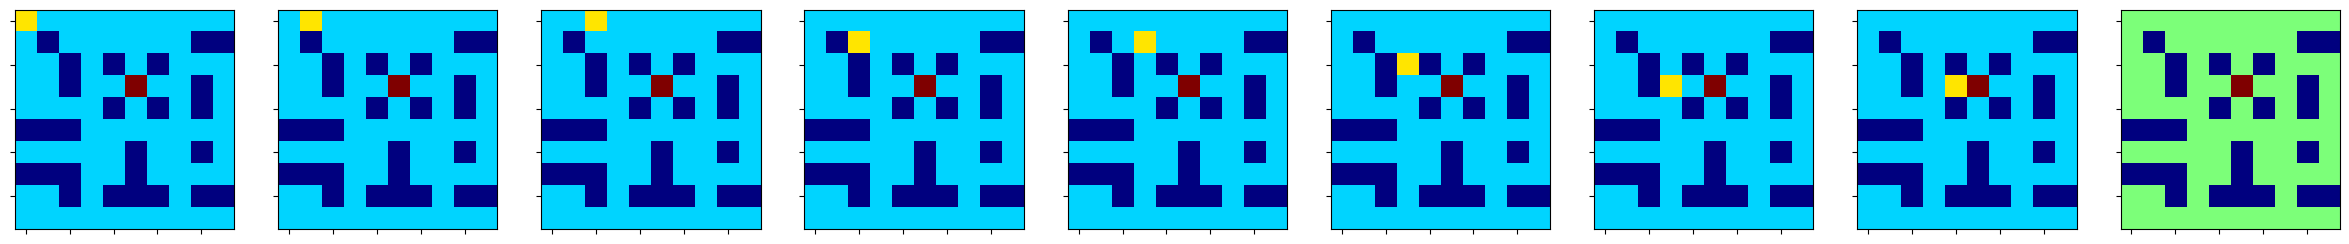

NodeID: 112
Parent: 76
Action: R
Cost:   8
State:
[1 1 1 1 1 1 1 1 1 1]
[1 0 1 1 1 1 1 1 0 0]
[1 1 0 1 0 1 0 1 1 1]
[1 1 0 1 1 2 1 1 0 1]
[1 1 1 1 0 1 0 1 0 1]
[0 0 0 1 1 1 1 1 1 1]
[1 1 1 1 1 0 1 1 0 1]
[0 0 0 1 1 0 1 1 1 1]
[1 1 0 1 0 0 0 1 0 0]
[1 1 1 1 1 1 1 1 1 1]

Explored Nodes: 155

=== Running DFS ===
DFS ran for: 0.017734527587890625 seconds


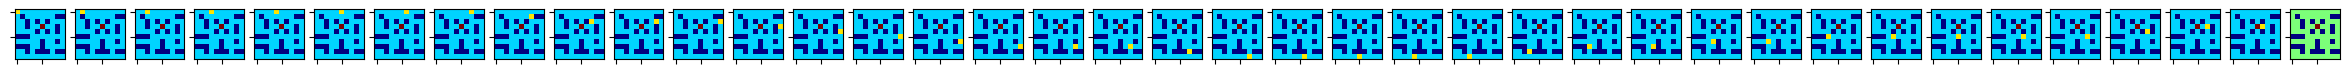

NodeID: 134
Parent: 132
Action: L
Cost:   38
State:
[1 1 1 1 1 1 1 1 1 1]
[1 0 1 1 1 1 1 1 0 0]
[1 1 0 1 0 1 0 1 1 1]
[1 1 0 1 1 2 1 1 0 1]
[1 1 1 1 0 1 0 1 0 1]
[0 0 0 1 1 1 1 1 1 1]
[1 1 1 1 1 0 1 1 0 1]
[0 0 0 1 1 0 1 1 1 1]
[1 1 0 1 0 0 0 1 0 0]
[1 1 1 1 1 1 1 1 1 1]

Explored Nodes: 135

=== Running Dijkstra ===
Dijkstra ran for: 0.04080033302307129 seconds


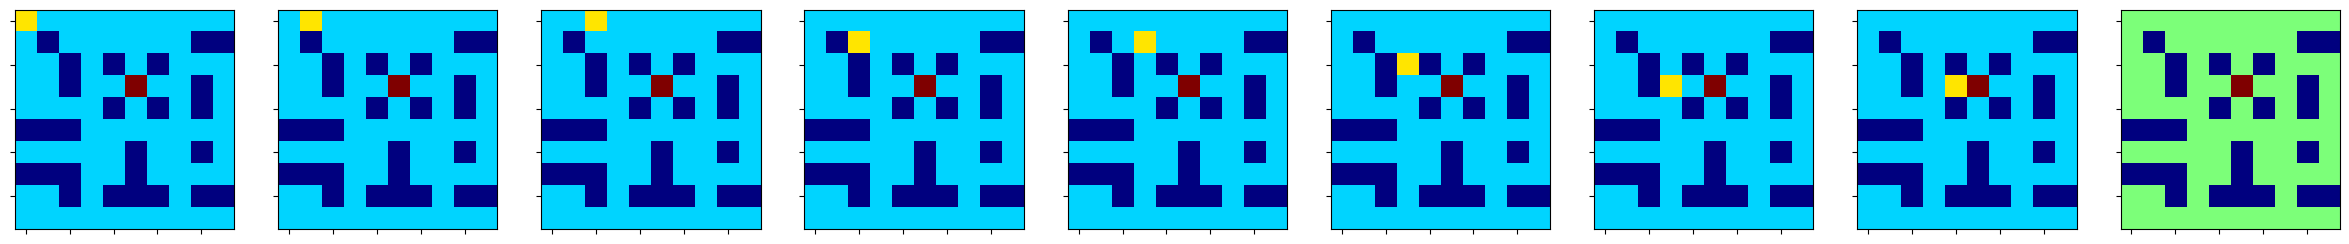

(56, <__main__.Node object at 0x78a485293460>)
Explored Nodes: 155

=== Running A* ===
BFS ran for: 0.008794784545898438 seconds


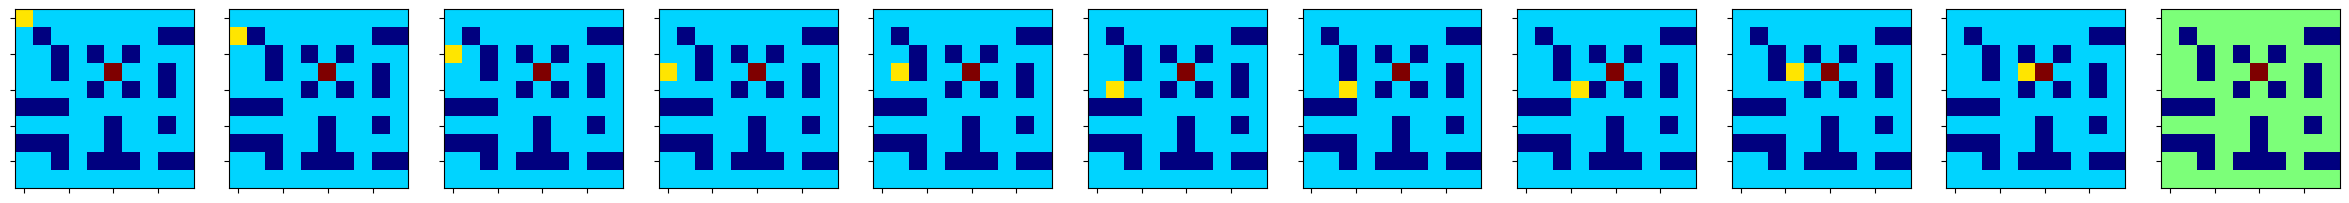

NodeID: 41
Parent: 39
Action: R
Cost:   34
State:
[1 1 1 1 1 1 1 1 1 1]
[1 0 1 1 1 1 1 1 0 0]
[1 1 0 1 0 1 0 1 1 1]
[1 1 0 1 1 2 1 1 0 1]
[1 1 1 1 0 1 0 1 0 1]
[0 0 0 1 1 1 1 1 1 1]
[1 1 1 1 1 0 1 1 0 1]
[0 0 0 1 1 0 1 1 1 1]
[1 1 0 1 0 0 0 1 0 0]
[1 1 1 1 1 1 1 1 1 1]

Explored Nodes: 44


In [25]:
search = Searches()

p = Problem()
s = State()

p.initialState = State(s)
print(s.position, " ", s.goalpos)
print(s.board)

print('=== Running BFS ===')
res = search.BFS(p)
print(res)
print("Explored Nodes: " + str(Node.nodeCount) + "\n")
Node.nodeCount = 0

print('=== Running DFS ===')
res = search.DFS(p)
print(res)
print("Explored Nodes: " + str(Node.nodeCount) + "\n")
Node.nodeCount = 0

print('=== Running Dijkstra ===')
res = search.dijkstra(p)
print(res)
print("Explored Nodes: " + str(Node.nodeCount) + "\n")
Node.nodeCount = 0

print('=== Running A* ===')
res = search.A_star(p)
print(res)
print("Explored Nodes: " + str(Node.nodeCount) + "\n")
Node.nodeCount = 0
